In [ ]:
!pip install dowhy
import pandas as pd
import numpy as np
from dowhy import CausalModel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.4/192.4 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.11
    Uninstalling Cython-3.0.11:
      Successfully uninstalled Cython-3.0.11


In [ ]:
# Load the uploaded dataset
file_path = 'SADCQ_2023_clean_final.csv'
data = pd.read_csv(file_path)

# Define mappings for interpretation (as provided in your setup)
mapping = {
    "q25": {1.0: "Yes", 2.0: "No", np.nan: "Null"},
    "q24": {1.0: "Yes", 2.0: "No", np.nan: "Null"},
    "q84": {
        1.0: "Never",
        2.0: "Rarely",
        3.0: "Sometimes",
        4.0: "Most of the time",
        5.0: "Always",
        np.nan: "Null",
    },
    "q49": {
        1.0: "0 times",
        2.0: "1 or 2 times",
        3.0: "3 to 9 times",
        4.0: "10 to 19 times",
        5.0: "20 to 39 times",
        6.0: "40 or more times",
        np.nan: "Null",
    },
    "q52": {
        1.0: "0 times",
        2.0: "1 or 2 times",
        3.0: "3 to 9 times",
        4.0: "10 to 19 times",
        5.0: "20 to 39 times",
        6.0: "40 or more times",
        np.nan: "Null",
    },
    "q42": {
        1.0: "0 days",
        2.0: "1 or 2 days",
        3.0: "3 to 5 days",
        4.0: "6 to 9 days",
        5.0: "10 to 19 days",
        6.0: "20 to 29 days",
        7.0: "All 30 days",
        np.nan: "Null",
    },
    "q14": {
        1.0: "0 days",
        2.0: "1 day",
        3.0: "2 or 3 days",
        4.0: "4 or 5 days",
        5.0: "6 or more days",
        np.nan: "Null",
    },
    "grade": {
        1.0: "9th grade",
        2.0: "10th grade",
        3.0: "11th grade",
        4.0: "12th grade",
        5.0: "Ungraded or other grade",
    },
    "sex": {1.0: "Female", 2.0: "Male"},
    "race7": {
        1.0: "American Indian/Alaska Native",
        2.0: "Asian",
        3.0: "Black or African American",
        4.0: "Hispanic/Latino",
        5.0: "Native Hawaiian/Other Pacific Islander",
        6.0: "White",
        7.0: "Multiple Races (Non-Hispanic)",
    },
    "age": {
        1.0: "12 years old or younger",
        2.0: "13 years old",
        3.0: "14 years old",
        4.0: "15 years old",
        5.0: "16 years old",
        6.0: "17 years old",
        7.0: "18 years old or older",
    },
    "qclose2people": {
        1.0: "Strongly agree",
        2.0: "Agree",
        3.0: "Not sure",
        4.0: "Disagree",
        5.0: "Strongly disagree",
        np.nan: "Null",
    },
}

mapping2 = {
    "q25": "Q25 - Electronically bullied",
    "q24": "Q24 - School bullied",
    "q84": "Q84 - Mental health",
    "q49": "Q49 - Prescription pill",
    "q52": "Q52 - Heroin taken",
    "q42": "Q42 - Alcohol",
    "q14": "Q14 - School unsafe",
    "qclose2people": "Q - Close to people",
    "sex": "Sex",
    "race7": "Race",
    "grade": "Grade",
    "age": "Age",
    "sitename": "Location",
}

# Apply mappings
# data_cleaned = data.replace(mapping)
data_cleaned = data.rename(columns=mapping2)

# Feature grouping for clarity
feature_groups = {
    "Demographics": ["Age", "Sex", "Grade", "Race"],
    "Mental and Behavioral": [
        "Q84 - Mental health",
        "Q42 - Alcohol",
        "Q49 - Prescription pill",
        "Q52 - Heroin taken",
    ],
    "Bullying and Safety": [
        "Q24 - School bullied",
        "Q25 - Electronically bullied",
        "Q14 - School unsafe",
        "Q - Close to people",
    ],
}

# Define treatment and outcome
outcome = "Label"
treatment = "Q24 - School bullied"

# Prepare data for causal analysis
causal_analysis_data = data_cleaned[
    feature_groups["Demographics"]
    + feature_groups["Mental and Behavioral"]
    + feature_groups["Bullying and Safety"]
    + [outcome] + ["weight"]
]

# Replicate rows based on weight
causal_analysis_data_weighted = causal_analysis_data.loc[
    causal_analysis_data.index.repeat(causal_analysis_data["weight"].astype(int))
]

# Resampling
from imblearn.over_sampling import SMOTE

# Define features and target
X = causal_analysis_data_weighted.drop(columns=["Label", "weight"])
y = causal_analysis_data_weighted["Label"]

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Verify new distribution
print(pd.Series(y_balanced).value_counts())

causal_analysis_data_weighted = pd.concat([X_balanced, y_balanced], axis=1)

# Build causal model
model = CausalModel(
    data=causal_analysis_data_weighted,
    treatment=treatment,
    outcome=outcome,
    common_causes=feature_groups["Demographics"] + feature_groups["Mental and Behavioral"],
)

# View the causal model
def visualize_model():
    model.view_model()
    print("Causal model visualization saved.")

# Identify and estimate causal effects
identified_estimand = model.identify_effect()
causal_effect = model.estimate_effect(
    identified_estimand, method_name="backdoor.linear_regression",
    # sample_weight=causal_analysis_data_weighted["normalized_weight"]
)

# Print causal effect summary
def causal_summary():
    print(causal_effect)

Label
1    294503
3    294503
2    294503
Name: count, dtype: int64


TypeError: CausalModel.identify_effect() got an unexpected keyword argument 'proceed_with_estimation'

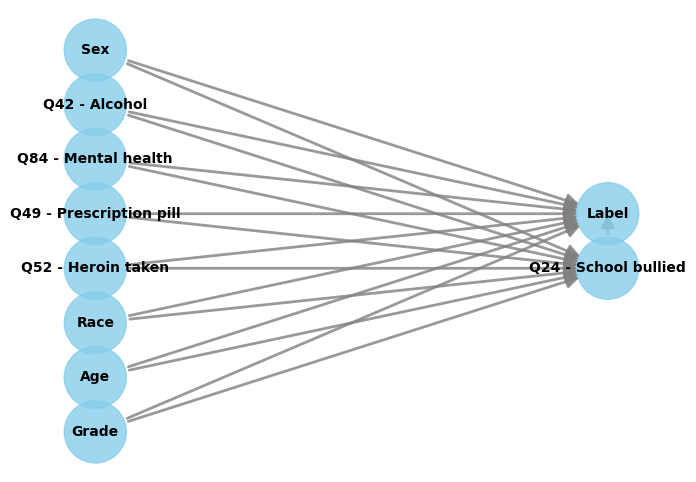

Causal model visualization saved.


In [ ]:
visualize_model()

In [ ]:
causal_summary()

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
           d                                                                                       ↪
───────────────────────(E[Label|Q42 - Alcohol,Q49 - Prescription pill,Race,Age,Grade,Q52 - Heroin  ↪
d[Q24 - School bullied]                                                                            ↪

↪                                
↪ taken,Q84 - Mental health,Sex])
↪                                
Estimand assumption 1, Unconfoundedness: If U→{Q24 - School bullied} and U→Label then P(Label|Q24 - School bullied,Q42 - Alcohol,Q49 - Prescription pill,Race,Age,Grade,Q52 - Heroin taken,Q84 - Mental health,Sex,U) = P(Label|Q24 - School bullied,Q42 - Alcohol,Q49 - Prescription pill,Race,Age,Grade,Q52 - Heroin taken,Q84 - Mental health,Sex)

## Realized estimand
b: Label~Q24 - School bullied+Q42 - Alcohol+Q49 - Prescription pill+Race+

In [ ]:
for feature in feature_groups["Bullying and Safety"]:
    model = CausalModel(
      data=causal_analysis_data_weighted,
      treatment=feature,
      outcome=outcome,
      common_causes=feature_groups["Demographics"] + feature_groups["Mental and Behavioral"],
  )

    # Identify and estimate causal effects
    identified_estimand = model.identify_effect()
    causal_effect = model.estimate_effect(
        identified_estimand, method_name="backdoor.linear_regression"
    )
    print(f"Causal Effect of {feature}: {causal_effect.value}")

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q24 - School bullied: -0.3467538215824728


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q25 - Electronically bullied: -0.3824266214194374


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q14 - School unsafe: 0.11544220458374133
Causal Effect of Q - Close to people: 0.04260494890223265


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [ ]:
# Define potential treatments and common causes
treatments = [
    "Q24 - School bullied",
    "Q25 - Electronically bullied",
    "Q84 - Mental health",
    "Q42 - Alcohol",
    "Q49 - Prescription pill",
    "Q52 - Heroin taken",
    "Q14 - School unsafe",
    "Q - Close to people",
]

common_causes = [
    "Sex",
    "Grade",
    "Age",
    "Race",
    "Q84 - Mental health",
    "Q42 - Alcohol",
    "Q49 - Prescription pill",
]

# Iterate through all combinations and estimate effects
results = []
for treatment in treatments:
    print(f"Analyzing treatment: {treatment}")
    common_causes_corrected = []
    for common_cause in common_causes:
      if treatment == common_cause:
        continue
      common_causes_corrected.append(common_cause)
    model = CausalModel(
        data=causal_analysis_data_weighted,
        treatment=treatment,
        outcome="Label",
        common_causes=common_causes_corrected
    )
    identified_estimand = model.identify_effect()
    causal_effect = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    results.append((treatment, causal_effect.value))
    print(f"Causal Effect of {treatment}: {causal_effect.value}")

# Output all results
for treatment, effect in results:
    print(f"Treatment: {treatment}, Causal Effect: {effect}")

Analyzing treatment: Q24 - School bullied


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q24 - School bullied: -0.3490315935995172
Analyzing treatment: Q25 - Electronically bullied


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q25 - Electronically bullied: -0.38498240581960586
Analyzing treatment: Q84 - Mental health


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q84 - Mental health: 0.23070626747896394
Analyzing treatment: Q42 - Alcohol


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q42 - Alcohol: 0.10601817339544706
Analyzing treatment: Q49 - Prescription pill


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q49 - Prescription pill: 0.11960522675882967
Analyzing treatment: Q52 - Heroin taken


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q52 - Heroin taken: 0.07369377221989826
Analyzing treatment: Q14 - School unsafe


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


Causal Effect of Q14 - School unsafe: 0.11765975897676628
Analyzing treatment: Q - Close to people
Causal Effect of Q - Close to people: 0.043407564587083725
Treatment: Q24 - School bullied, Causal Effect: -0.3490315935995172
Treatment: Q25 - Electronically bullied, Causal Effect: -0.38498240581960586
Treatment: Q84 - Mental health, Causal Effect: 0.23070626747896394
Treatment: Q42 - Alcohol, Causal Effect: 0.10601817339544706
Treatment: Q49 - Prescription pill, Causal Effect: 0.11960522675882967
Treatment: Q52 - Heroin taken, Causal Effect: 0.07369377221989826
Treatment: Q14 - School unsafe, Causal Effect: 0.11765975897676628
Treatment: Q - Close to people, Causal Effect: 0.043407564587083725


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


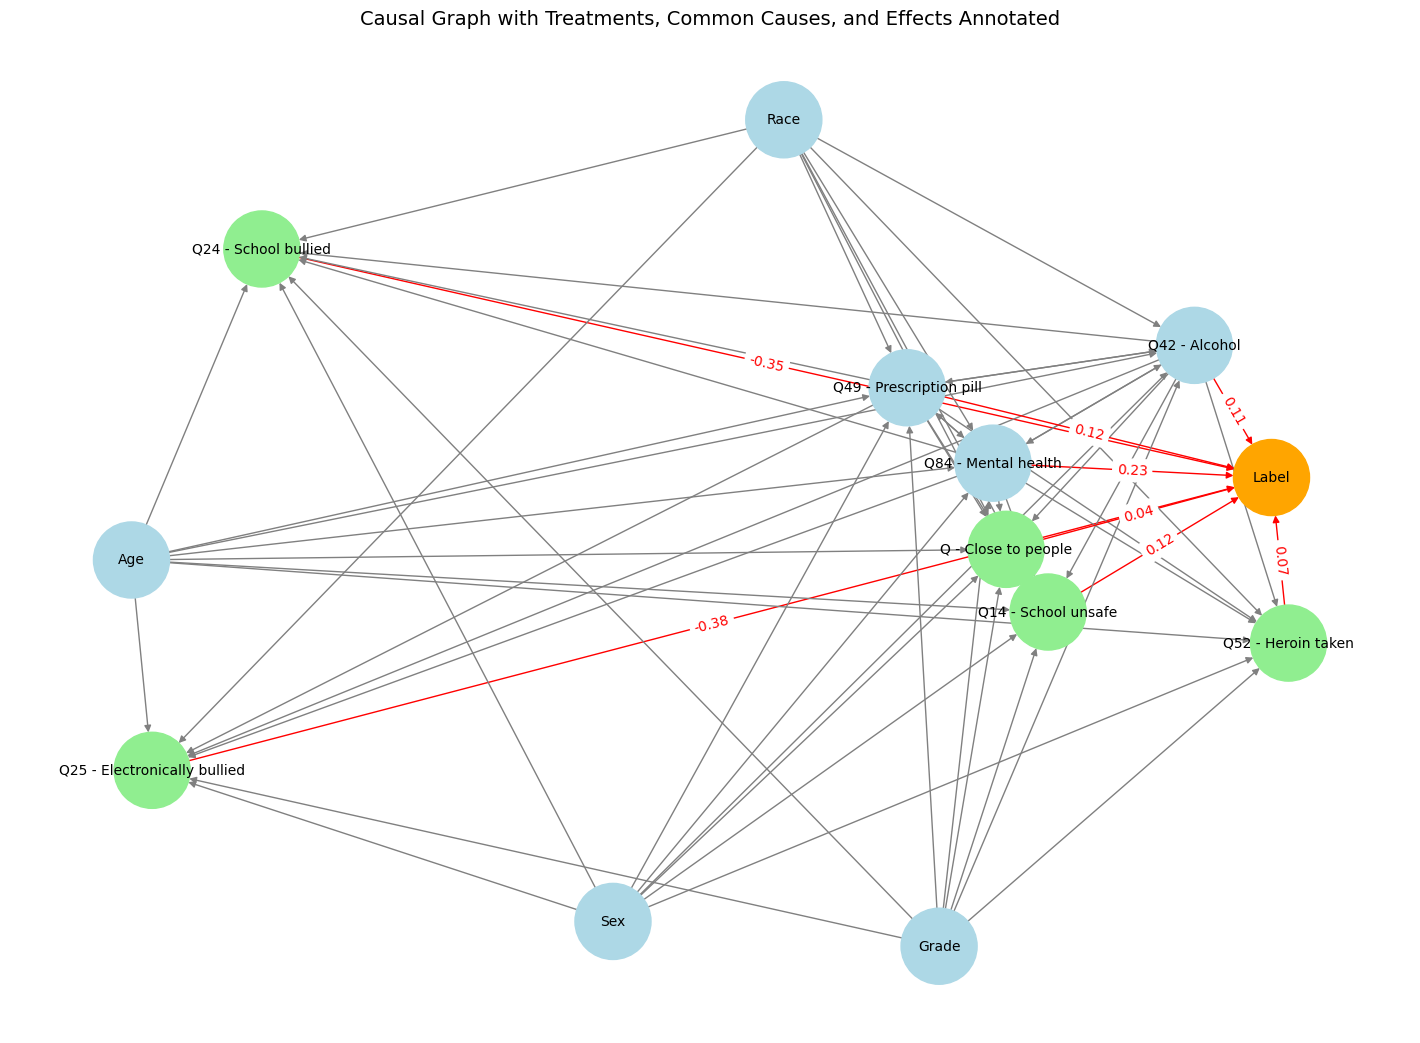


Causal Effects Summary:
Treatment: Q24 - School bullied, Causal Effect: -0.3490315935995172
Treatment: Q25 - Electronically bullied, Causal Effect: -0.38498240581960586
Treatment: Q84 - Mental health, Causal Effect: 0.23070626747896394
Treatment: Q42 - Alcohol, Causal Effect: 0.10601817339544706
Treatment: Q49 - Prescription pill, Causal Effect: 0.11960522675882967
Treatment: Q52 - Heroin taken, Causal Effect: 0.07369377221989826
Treatment: Q14 - School unsafe, Causal Effect: 0.11765975897676628
Treatment: Q - Close to people, Causal Effect: 0.043407564587083725


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# Add nodes and edges for treatments and their causal effects
for treatment, effect in results:
    G.add_node(treatment, node_type="treatment")
    G.add_edge(treatment, "Label", weight=effect, edge_type="treatment_effect")

# Add nodes and edges for common causes
for cause in common_causes:
    G.add_node(cause, node_type="common_cause")
    for treatment, _ in results:
        if cause != treatment:  # Avoid redundant edges
            G.add_edge(cause, treatment, weight=0, edge_type="common_cause")

# Add node for the outcome
G.add_node("Label", node_type="outcome")

# Define node colors based on type
node_colors = []
for node, data in G.nodes(data=True):
    if data["node_type"] == "treatment":
        node_colors.append("lightgreen")
    elif data["node_type"] == "common_cause":
        node_colors.append("lightblue")
    elif data["node_type"] == "outcome":
        node_colors.append("orange")

# Define edge styles based on type
edge_styles = []
for u, v, data in G.edges(data=True):
    if data["edge_type"] == "treatment_effect":
        edge_styles.append("red")
    else:
        edge_styles.append("gray")

# Draw the complete graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # Layout for consistent graph positioning
nx.draw(
    G, pos, with_labels=True, node_color=node_colors, edge_color=edge_styles, node_size=3000, font_size=10
)

# Annotate edges with causal effects
edge_labels = {
    (u, v): f"{d['weight']:.2f}" if d['weight'] != 0 else ""
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

plt.title("Causal Graph with Treatments, Common Causes, and Effects Annotated", fontsize=14)
plt.show()

# Output all results
print("\nCausal Effects Summary:")
for treatment, effect in results:
    print(f"Treatment: {treatment}, Causal Effect: {effect}")


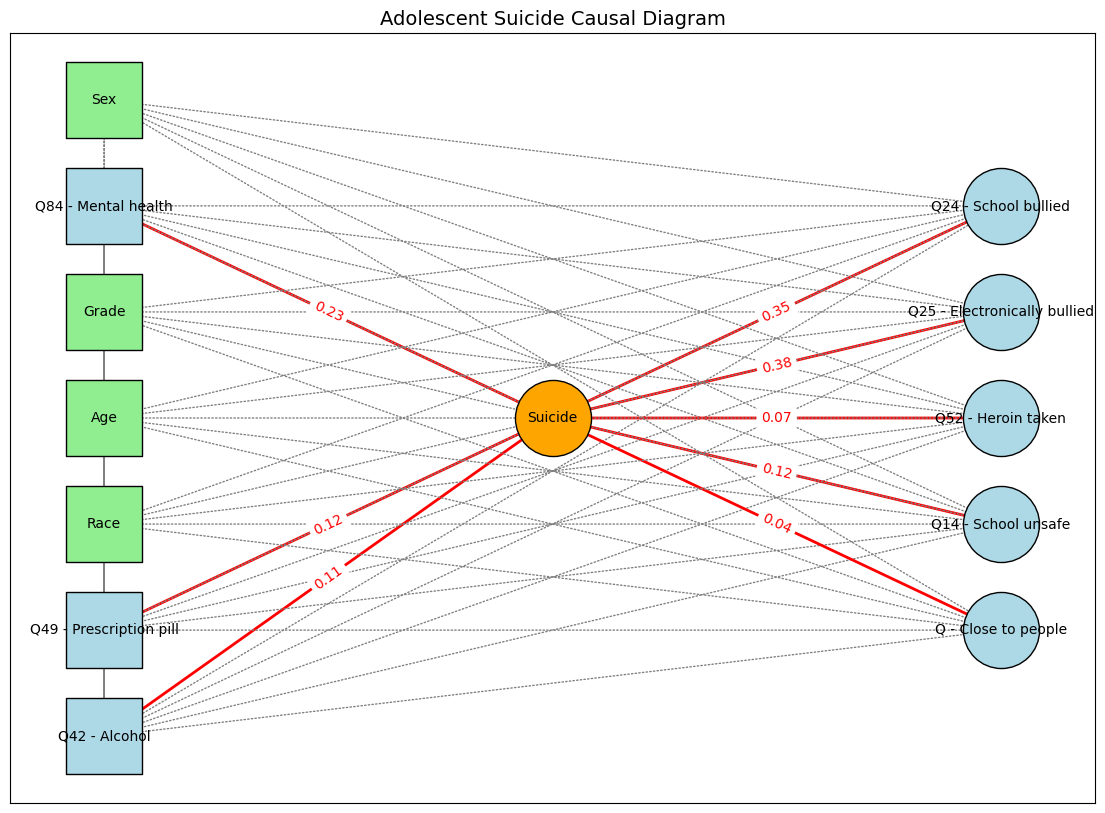


Causal Effects Summary:
Treatment: Q24 - School bullied, Causal Effect: -0.3490315935995172
Treatment: Q25 - Electronically bullied, Causal Effect: -0.38498240581960586
Treatment: Q84 - Mental health, Causal Effect: 0.23070626747896394
Treatment: Q42 - Alcohol, Causal Effect: 0.10601817339544706
Treatment: Q49 - Prescription pill, Causal Effect: 0.11960522675882967
Treatment: Q52 - Heroin taken, Causal Effect: 0.07369377221989826
Treatment: Q14 - School unsafe, Causal Effect: 0.11765975897676628
Treatment: Q - Close to people, Causal Effect: 0.043407564587083725


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()

# Add nodes and edges for treatments and their causal effects
for treatment, effect in results:
    G.add_node(treatment, node_type="treatment", subset=2)  # Mid-layer
    G.add_edge(treatment, "Suicide", weight=effect, edge_type="treatment_effect")

# Add nodes and edges for common causes
for cause in common_causes:
    if cause in [t[0] for t in results]:
        G.add_node(cause, node_type="both", subset=0)  # Both treatment and common cause
    else:
        G.add_node(cause, node_type="common_cause", subset=0)  # Outermost layer
    for treatment, _ in results:
        if cause != treatment:  # Avoid redundant edges
            G.add_edge(cause, treatment, weight=0, edge_type="common_cause")

# Add node for the outcome
G.add_node("Suicide", node_type="outcome", subset=1)  # Center layer

# Define node styles based on type
node_colors = []
node_shapes = []  # Dashed border for some types
for node, data in G.nodes(data=True):
    if data["node_type"] == "treatment":
        node_colors.append("lightblue")  # Treatment: solid blue
        node_shapes.append("solid")
    elif data["node_type"] == "common_cause":
        node_colors.append("lightgreen")  # Common cause: light green with dashed border
        node_shapes.append("dashed")
    elif data["node_type"] == "both":
        node_colors.append("lightblue")  # Both treatment and common cause: light blue with dashed border
        node_shapes.append("dashed")
    elif data["node_type"] == "outcome":
        node_colors.append("orange")  # Outcome: solid orange
        node_shapes.append("solid")

# Draw the graph layout using multipartite layout
plt.figure(figsize=(14, 10))
pos = nx.multipartite_layout(G, subset_key="subset")  # Use subset attribute for layers

# Draw nodes based on type
for node, shape, color in zip(G.nodes(), node_shapes, node_colors):
    if shape == "dashed":
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=3000, edgecolors="black", linewidths=1, node_shape="s")
    else:
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=3000, edgecolors="black", linewidths=1, node_shape="o")

# Draw edges
for u, v, data in G.edges(data=True):
    if data["edge_type"] == "treatment_effect":
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color="red", style="solid", width=2, arrows=True)
    else:
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], edge_color="gray", style="dotted", width=1, arrows=True)

# Add labels
nx.draw_networkx_labels(G, pos, font_size=10)

# Annotate edges with causal effects
edge_labels = {
    (u, v): f"{abs(d['weight']):.2f}" if d['weight'] != 0 else ""
    for u, v, d in G.edges(data=True)
}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red", font_size=10)

plt.title("Adolescent Suicide Causal Diagram", fontsize=14)
plt.show()

# Output all results
print("\nCausal Effects Summary:")
for treatment, effect in results:
    print(f"Treatment: {treatment}, Causal Effect: {effect}")
